In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
paths = {'Original': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.TP10K.h5ad'}

# Run cNMF

In [3]:
cnmfdir = '../../../Data/PerDataset/Pancancer'
name = 'PanCancer.20232005.NoBlood'

In [88]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 60)
n_iter = 20
num_per_node = 5

In [4]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [90]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [20]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

180

In [24]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(90, 180):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J PanCancer.20232005.NoBlood -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.90.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.90.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name PanCancer.20232005.NoBlood --output-dir ../../../Data/PerDataset/Pancancer --total-workers 180 --worker-index 90"
Job <886923> is submitted to queue <short>.
bsub -q short -J PanCancer.20232005.NoBlood -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.91.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.91.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]"

In [25]:
! bjobs

No unfinished job found


In [26]:
! bjobs | wc -l

No unfinished job found
0


In [35]:
! ls ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/cnmf_tmp/*spectra*  | wc -l

826


In [36]:
len(Ks)

45

In [23]:
total_workers = int((len(Ks)*n_iter))
total_workers

900

In [24]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

822 ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/cnmf_tmp/PanCancer.20232005.NoBlood.spectra.k_56.iter_2.df.npz


In [25]:
len(missing)

1

In [26]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J PanCancer.20232005.NoBlood -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.822.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/log/PanCancer.20232005.NoBlood.822.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name PanCancer.20232005.NoBlood --output-dir ../../../Data/PerDataset/Pancancer --total-workers 900 --worker-index 822"
Job <887266> is submitted to queue <short>.


In [8]:
! bjobs | wc -l

No unfinished job found
0


In [9]:
! bjobs

No unfinished job found


In [20]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 1h 27min 38s, sys: 1h 4min 14s, total: 2h 31min 52s
Wall time: 13min 2s


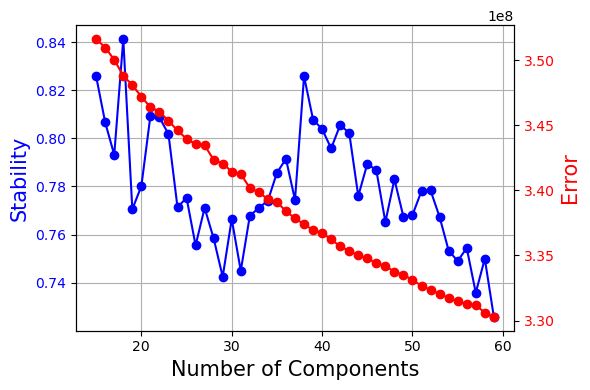

In [21]:
%%time
cnmf_obj.k_selection_plot()

In [5]:
figdir = '../../../Figures/Components'

In [6]:
cmd = 'cp {} {}'.format(cnmf_obj.paths['k_selection_plot'], 
                           os.path.join(figdir, '%s.k_selection.png' % name))

print(cmd)

cp ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/PanCancer.20232005.NoBlood.k_selection.png ../../../Figures/Components/PanCancer.20232005.NoBlood.k_selection.png


In [7]:
print(cmd)
! {cmd}

cp ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood/PanCancer.20232005.NoBlood.k_selection.png ../../../Figures/Components/PanCancer.20232005.NoBlood.k_selection.png


In [96]:
kthresh = {38:0.2, 43:0.2, 48:.2, 52:.2}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


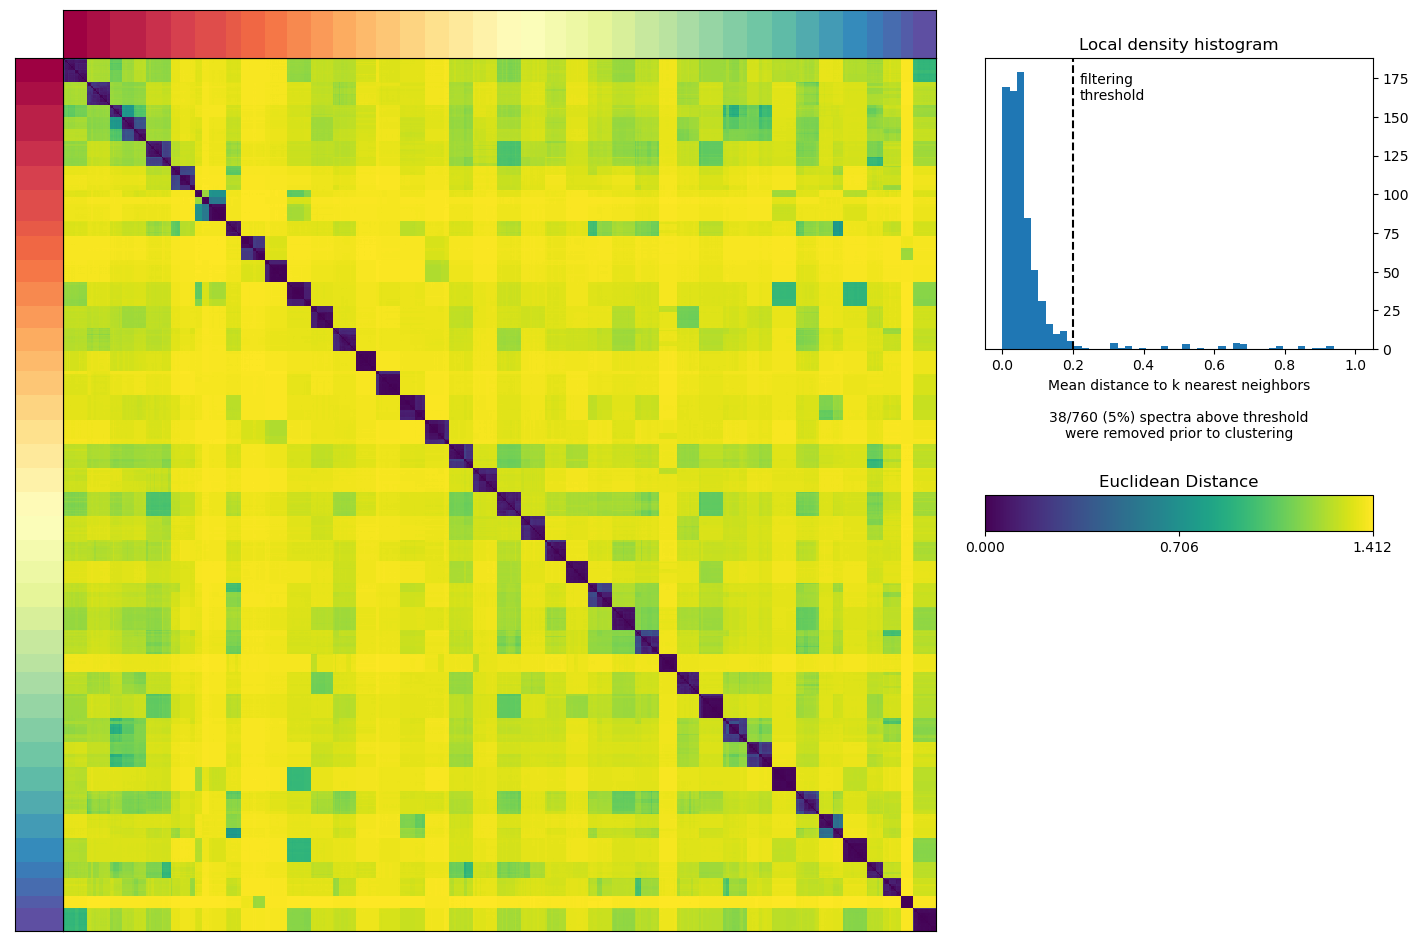

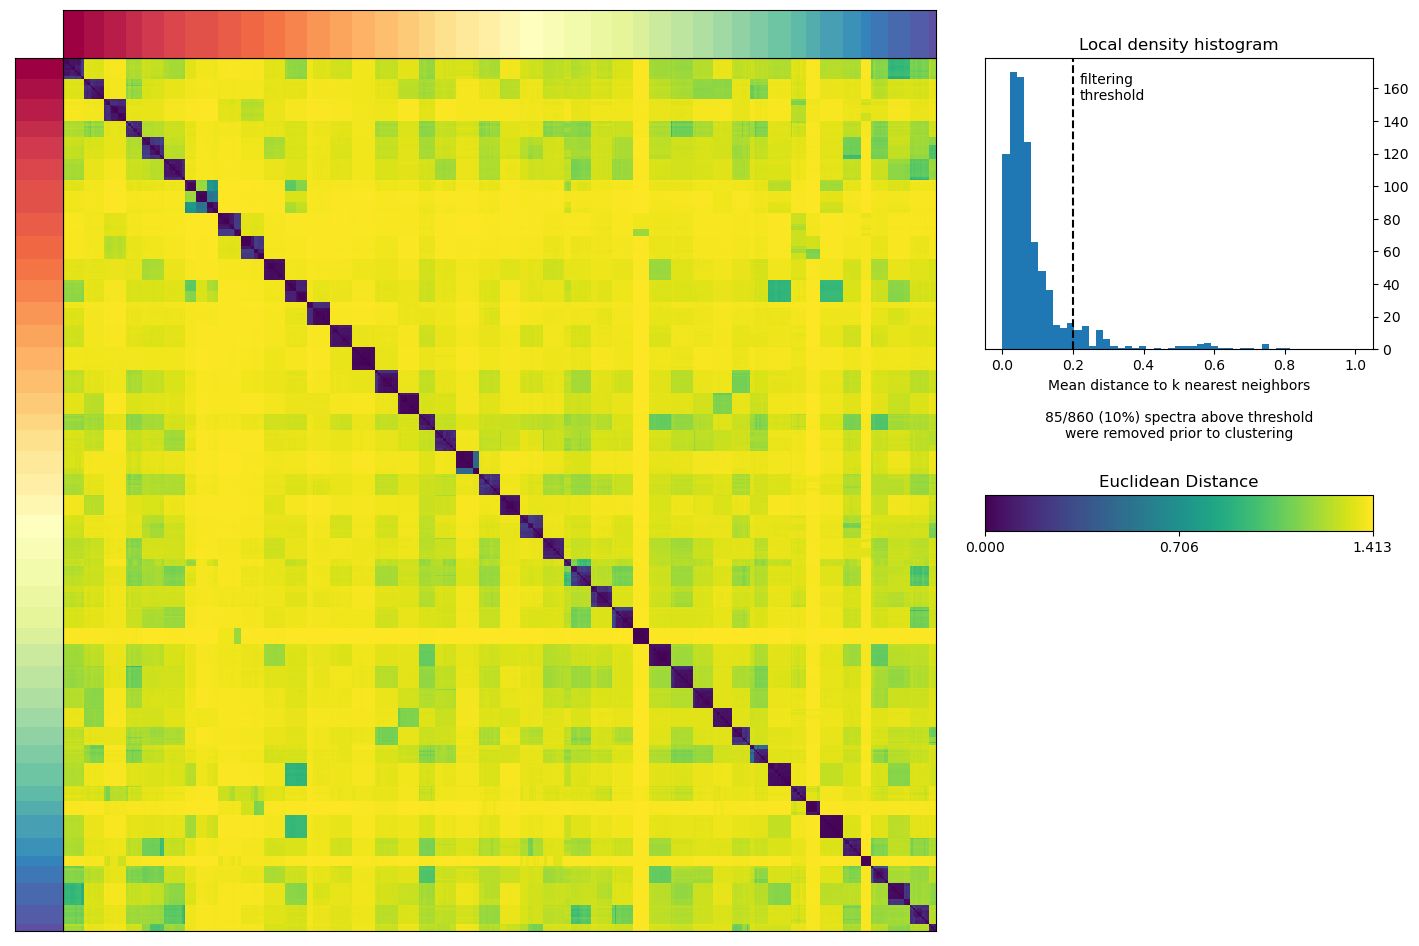

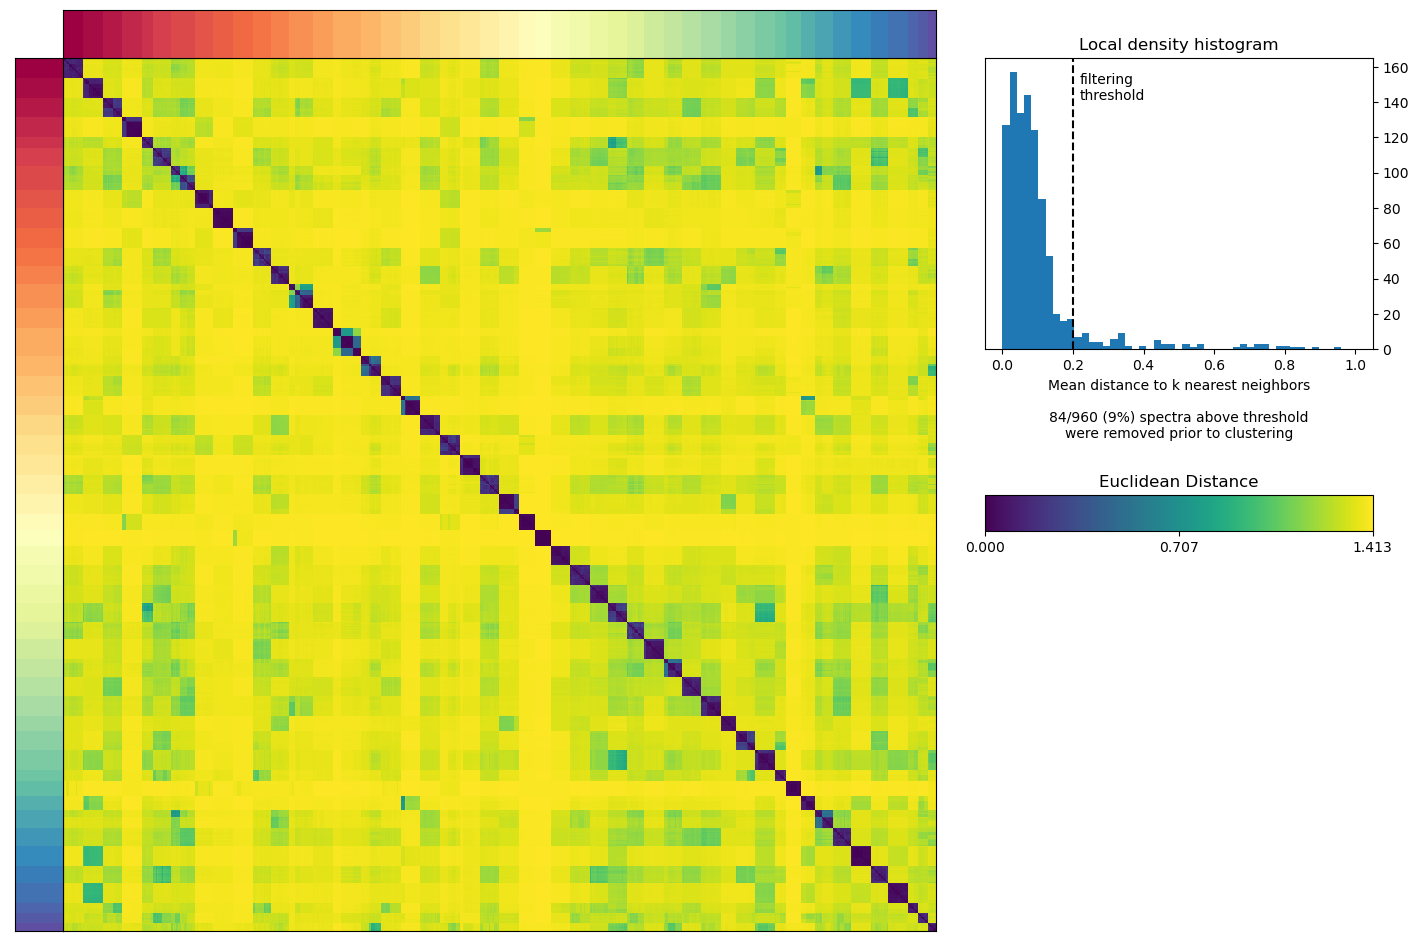

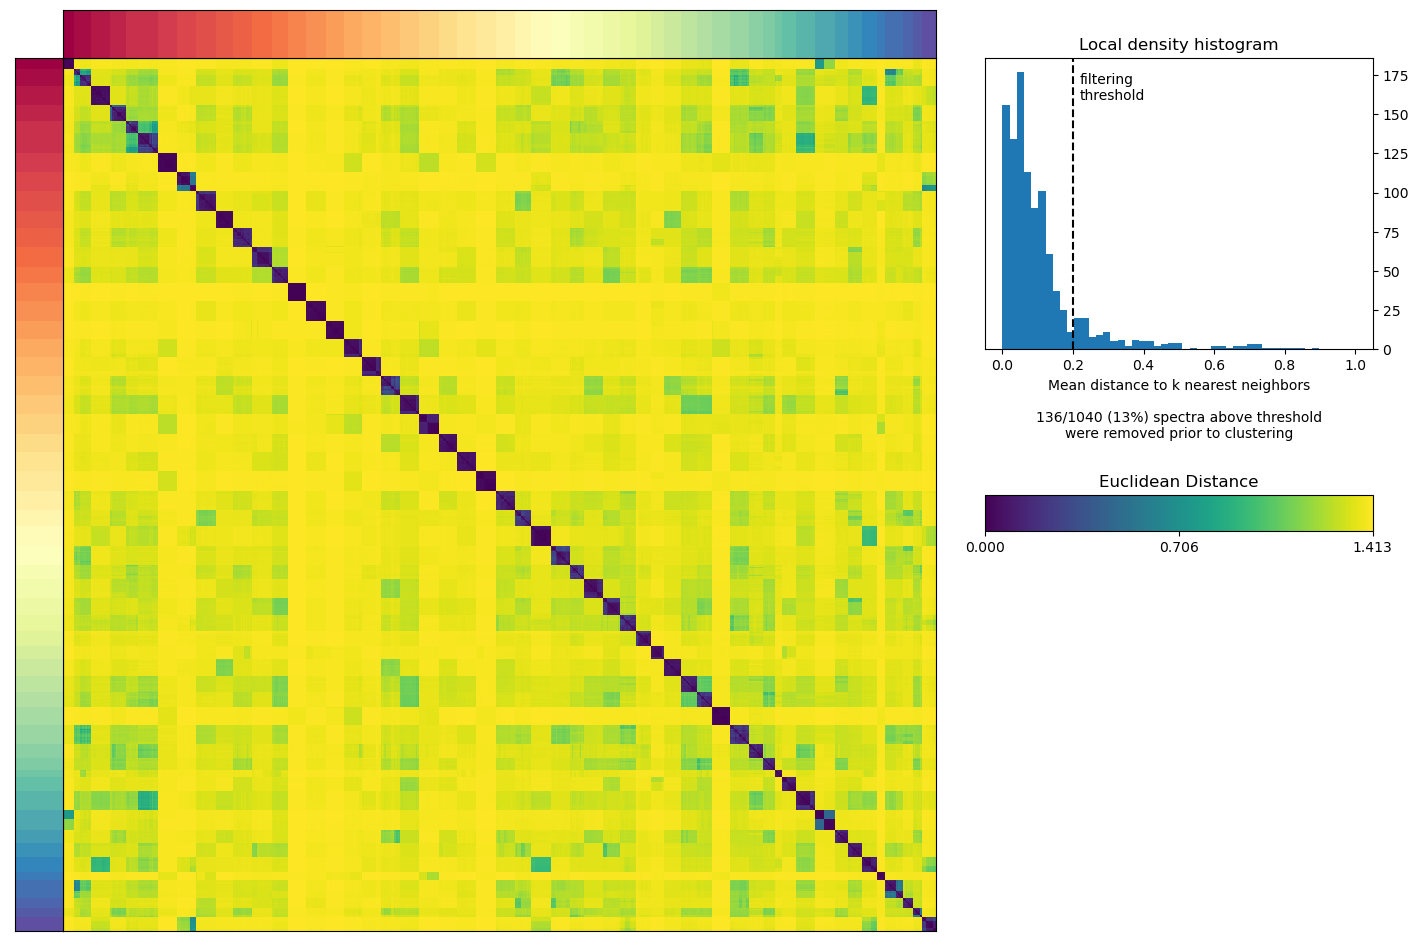

In [29]:
for k in [38, 43, 48, 52]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

## Compare with original TCATs

In [91]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [92]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA  \
CellCycle-G2M_CellCycle_G2M                  AMP-RA:CellCycle-G2M   
ISG                                                    AMP-RA:ISG   
gdT                                                           NaN   
Metallothionein                            AMP-RA:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  AMP-RA:CellCycle-Sphase   

                                                          UK-Covid  \
CellCycle-G2M_CellCycle_G2M                 UK-Covid:CellCycle_G2M   
ISG                                                   UK-Covid:ISG   
gdT                                                   UK-Covid:gdT   
Metallothionein                           UK-Covid:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      UK-Covid:CellCycle_S   

                                                           Pan-Tissue  \
CellCycle-G2M_CellCycle_G2M                  Pan-Tissue:CellCycle-G2M   
ISG                                                    Pan-Tissue:ISG   
gdT                                                               NaN   
Metallothionein                            Pan-Tissue:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Tissue:CellCycle-Sphase   

                                                        HIV-Vaccine  \
CellCycle-G2M_CellCycle_G2M               HIV-Vaccine:CellCycle_G2M   
ISG                                                 HIV-Vaccine:ISG   
gdT                                                 HIV-Vaccine:gdT   
Metallothionein                                                 NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    HIV-Vaccine:CellCycle_S   

                                                          COMBAT  \
CellCycle-G2M_CellCycle_G2M                 COMBAT:CellCycle_G2M   
ISG                                                   COMBAT:ISG   
gdT                                                   COMBAT:gdT   
Metallothionein                           COMBAT:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      COMBAT:CellCycle_S   

                                                        TBRU  \
CellCycle-G2M_CellCycle_G2M               TBRU:CellCycle_G2M   
ISG                                                 TBRU:ISG   
gdT                                                 TBRU:gdT   
Metallothionein                                          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    TBRU:DTL/FAM111B   

                                                           Pan-Cancer  
CellCycle-G2M_CellCycle_G2M                  Pan-Cancer:CellCycle-G2M  
ISG                                                    Pan-Cancer:ISG  
gdT                                                               NaN  
Metallothionein                            Pan-Cancer:Metallothionein  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Cancer:CellCycle-Sphase

In [93]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

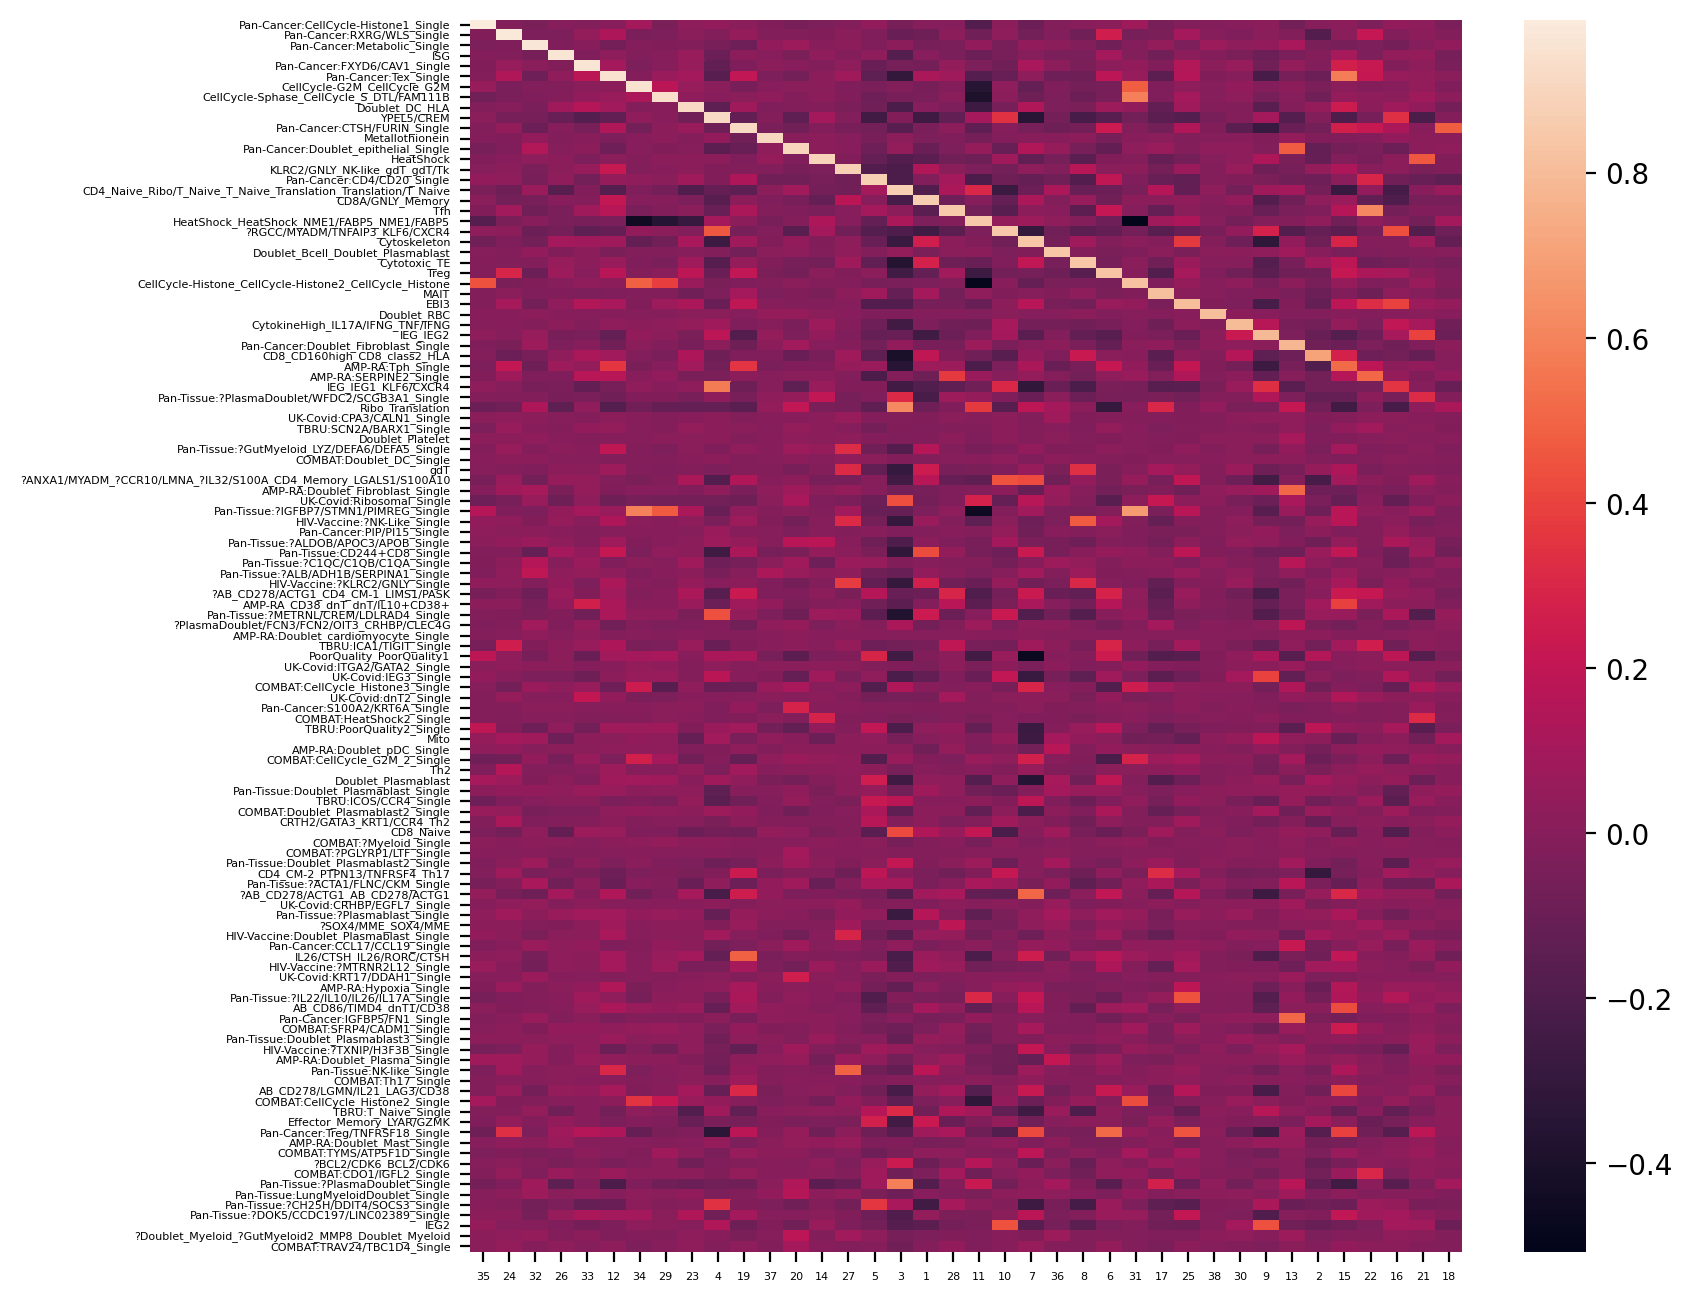

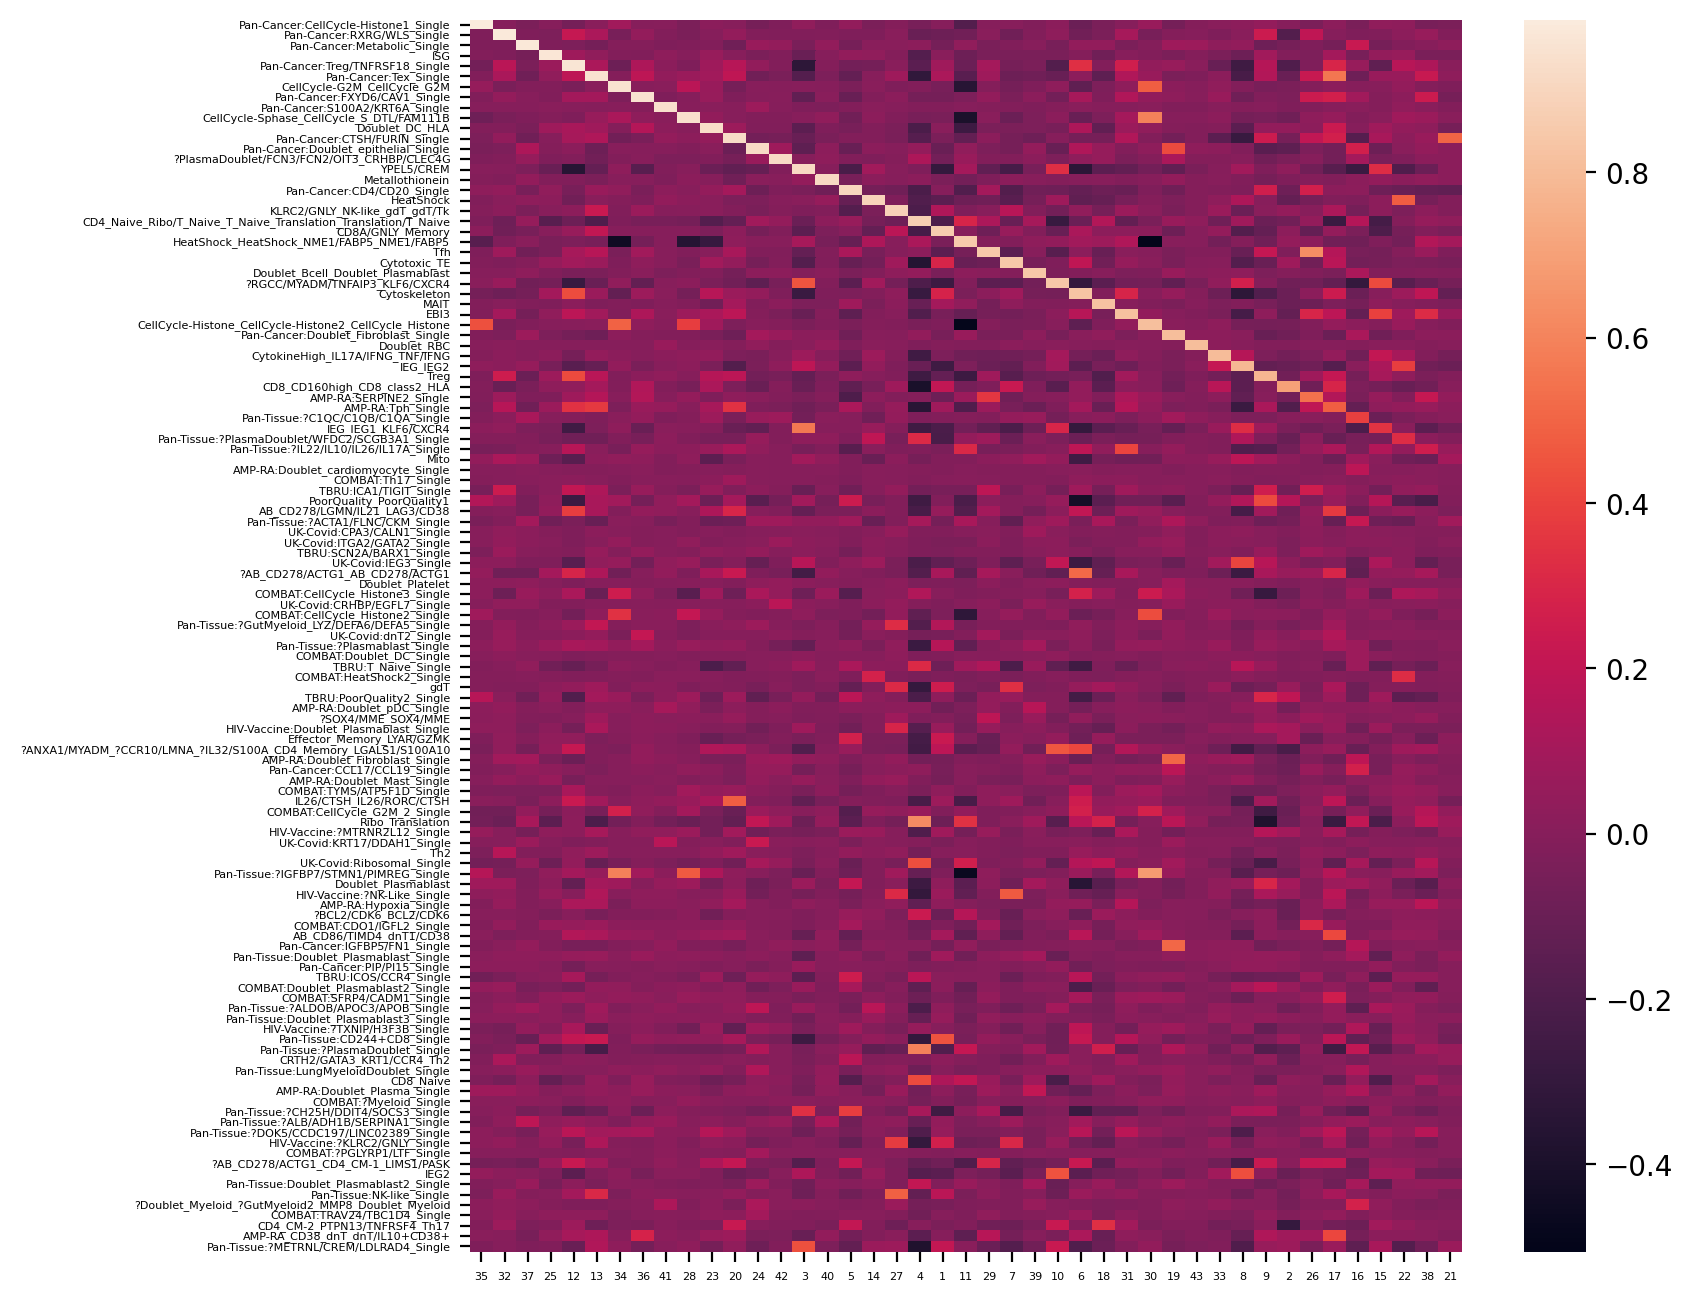

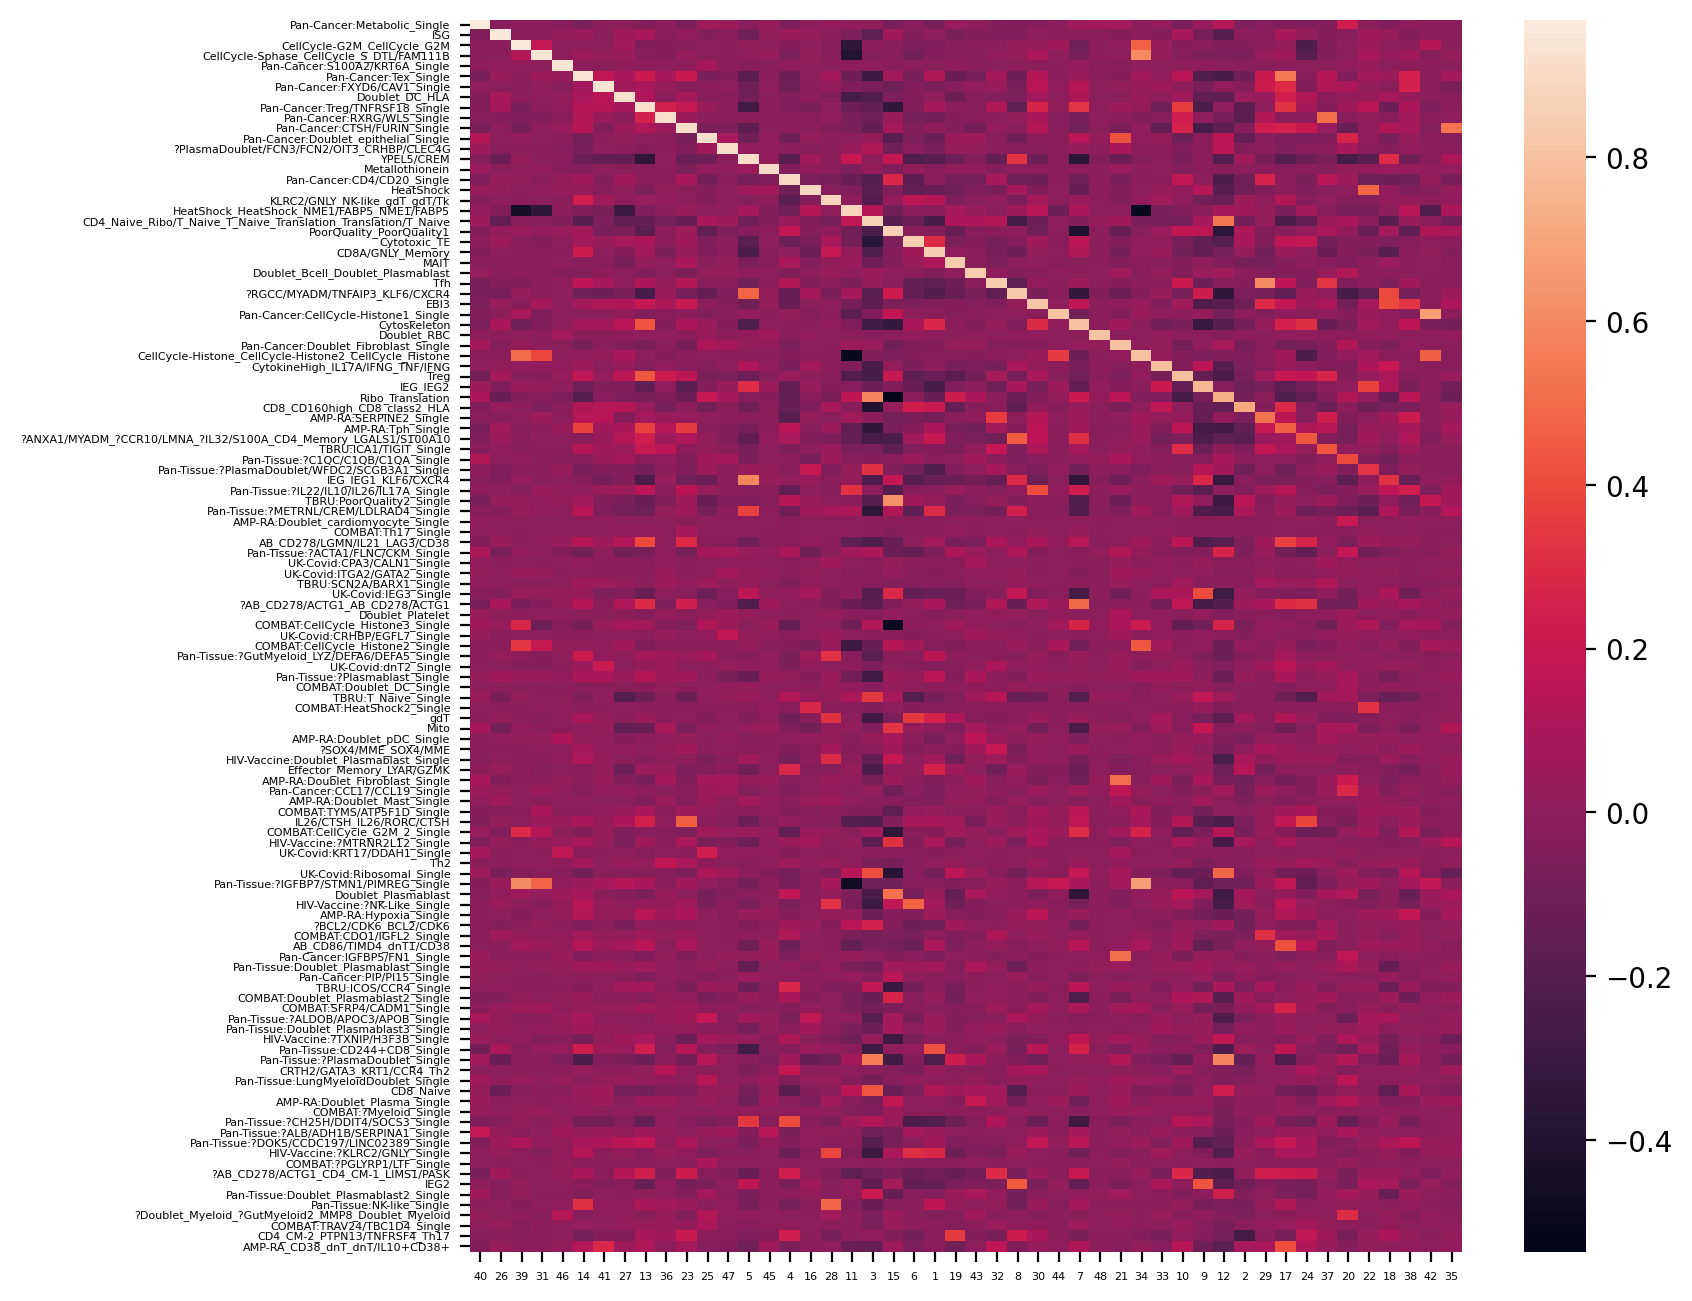

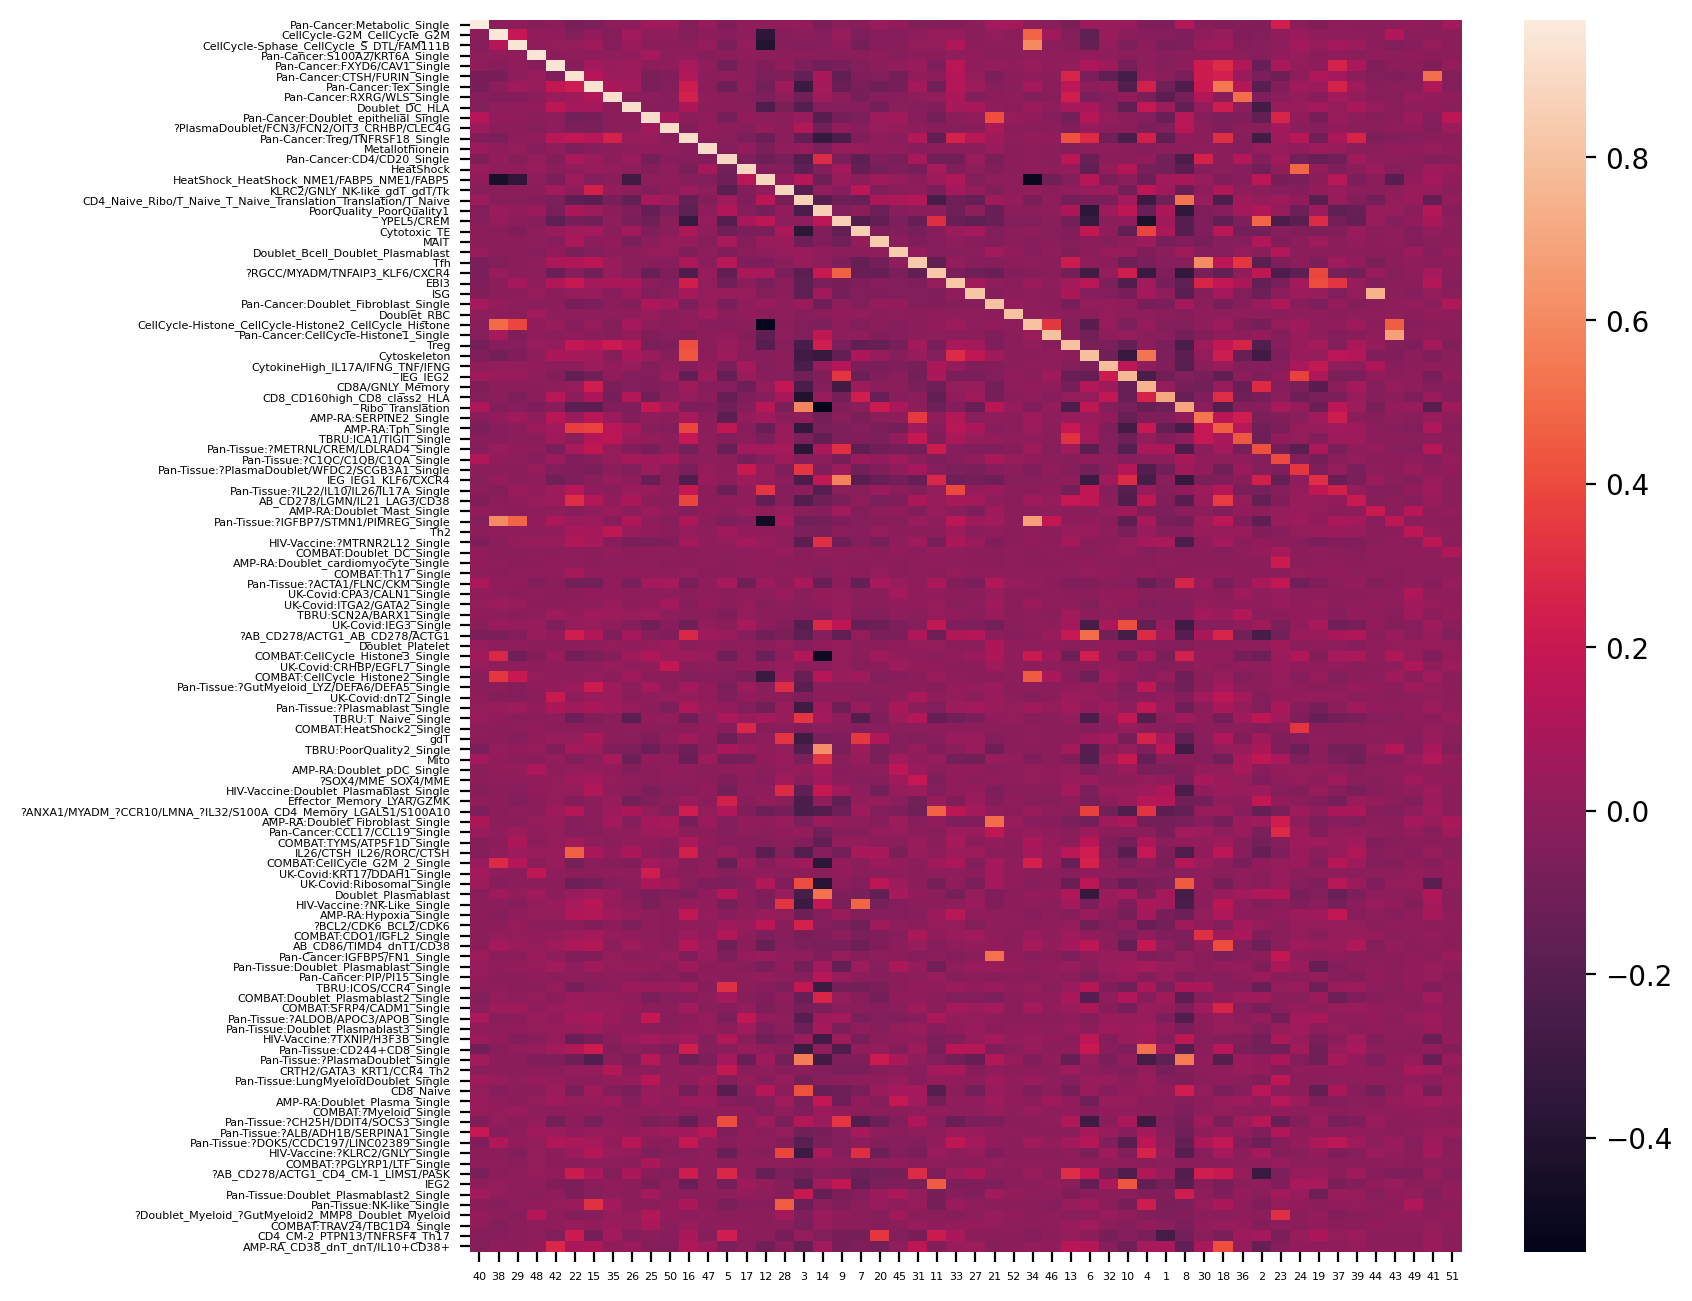

In [97]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'HIV-Vaccine', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'Pan-Cancer'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in [38, 43, 48, 52]:
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [98]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  38                33                             23   
1  43                36                             23   
2  48                38                             25   
3  52                38                             25   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            35                     10               5   
1                            35                     13               7   
2                            35                     13              10   
3                            35                     13              14   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0

In [99]:
k = 43
ind = ~mapping_ref[k]['R'].isnull()
mapping_ref[k].loc[ind,:]

Y_columns                                          X_columns  \
4111.0       35.0               Pan-Cancer:CellCycle-Histone1_Single   
3751.0       32.0                         Pan-Cancer:RXRG/WLS_Single   
4350.0       37.0                        Pan-Cancer:Metabolic_Single   
2858.0       25.0                                                ISG   
1368.0       12.0                    Pan-Cancer:Treg/TNFRSF18_Single   
1485.0       13.0                              Pan-Cancer:Tex_Single   
3927.0       34.0                        CellCycle-G2M_CellCycle_G2M   
4228.0       36.0                       Pan-Cancer:FXYD6/CAV1_Single   
4828.0       41.0                     Pan-Cancer:S100A2/KRT6A_Single   
3218.0       28.0           CellCycle-Sphase_CellCycle_S_DTL/FAM111B   
2634.0       23.0                                     Doublet_DC_HLA   
2319.0       20.0                       Pan-Cancer:CTSH/FURIN_Single   
2797.0       24.0               Pan-Cancer:Doublet_epithelial_Single   
4915.0       42.0         ?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G   
280.0         3.0                                         YPEL5/CREM   
4644.0       40.0                                    Metallothionein   
532.0         5.0                         Pan-Cancer:CD4/CD20_Single   
1556.0       14.0                                          HeatShock   
3114.0       27.0                      KLRC2/GNLY_NK-like_gdT_gdT/Tk   
392.0         4.0  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...   
47.0          1.0                                   CD8A/GNLY_Memory   
1214.0       11.0          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5   
3369.0       29.0                                                Tfh   
728.0         7.0                                       Cytotoxic_TE   
4561.0       39.0                  Doublet_Bcell_Doublet_Plasmablast   
1102.0       10.0                     ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4   
599.0         6.0                                       Cytoskeleton   
2029.0       18.0                                               MAIT   
3608.0       31.0                                               EBI3   
3459.0       30.0  CellCycle-Histone_CellCycle-Histone2_CellCycle...   
2203.0       19.0               Pan-Cancer:Doublet_Fibroblast_Single   
5005.0       43.0                                        Doublet_RBC   
3826.0       33.0                   CytokineHigh_IL17A/IFNG_TNF/IFNG   
852.0         8.0                                           IEG_IEG2   
967.0         9.0                                               Treg   
140.0         2.0                       CD8_CD160high_CD8_class2_HLA   
3025.0       26.0                             AMP-RA:SERPINE2_Single   
1952.0       17.0                                  AMP-RA:Tph_Single   
1894.0       16.0                  Pan-Tissue:?C1QC/C1QB/C1QA_Single   
1692.0       15.0                                IEG_IEG1_KLF6/CXCR4   
2607.0       22.0     Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single   
4509.0       38.0            Pan-Tissue:?IL22/IL10/IL26/IL17A_Single   
2390.0       21.0                                               Mito   

               R                    AMP-RA                    UK-Covid  \
4111.0  0.984564                       NaN                         NaN   
3751.0  0.978162                       NaN                         NaN   
4350.0  0.968223                       NaN                         NaN   
2858.0  0.961486                AMP-RA:ISG                UK-Covid:ISG   
1368.0  0.955759                       NaN                         NaN   
1485.0  0.948308                       NaN                         NaN   
3927.0  0.948230      AMP-RA:CellCycle-G2M      UK-Covid:CellCycle_G2M   
4228.0  0.945949                       NaN                         NaN   
4828.0  0.940720                       NaN                         NaN   
3218.0  0.938399   AMP-RA:CellCycle-Sphase        UK-Covid:CellCycle_S   
2634.0  0.929654         

In [100]:
k = 38
ind = ~mapping_ref[k]['R'].isnull()
mapping_ref[k].loc[ind,:]

Y_columns                                          X_columns  \
4111.0       35.0               Pan-Cancer:CellCycle-Histone1_Single   
2799.0       24.0                         Pan-Cancer:RXRG/WLS_Single   
3755.0       32.0                        Pan-Cancer:Metabolic_Single   
2977.0       26.0                                                ISG   
3871.0       33.0                       Pan-Cancer:FXYD6/CAV1_Single   
1366.0       12.0                              Pan-Cancer:Tex_Single   
3927.0       34.0                        CellCycle-G2M_CellCycle_G2M   
3337.0       29.0           CellCycle-Sphase_CellCycle_S_DTL/FAM111B   
2634.0       23.0                                     Doublet_DC_HLA   
399.0         4.0                                         YPEL5/CREM   
2200.0       19.0                       Pan-Cancer:CTSH/FURIN_Single   
4287.0       37.0                                    Metallothionein   
2321.0       20.0               Pan-Cancer:Doublet_epithelial_Single   
1556.0       14.0                                          HeatShock   
3114.0       27.0                      KLRC2/GNLY_NK-like_gdT_gdT/Tk   
532.0         5.0                         Pan-Cancer:CD4/CD20_Single   
273.0         3.0  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...   
47.0          1.0                                   CD8A/GNLY_Memory   
3250.0       28.0                                                Tfh   
1214.0       11.0          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5   
1102.0       10.0                     ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4   
718.0         7.0                                       Cytoskeleton   
4204.0       36.0                  Doublet_Bcell_Doublet_Plasmablast   
847.0         8.0                                       Cytotoxic_TE   
610.0         6.0                                               Treg   
3578.0       31.0  CellCycle-Histone_CellCycle-Histone2_CellCycle...   
1910.0       17.0                                               MAIT   
2894.0       25.0                                               EBI3   
4410.0       38.0                                        Doublet_RBC   
3469.0       30.0                   CytokineHigh_IL17A/IFNG_TNF/IFNG   
971.0         9.0                                           IEG_IEG2   
1489.0       13.0               Pan-Cancer:Doublet_Fibroblast_Single   
140.0         2.0                       CD8_CD160high_CD8_class2_HLA   
1714.0       15.0                                  AMP-RA:Tph_Single   
2549.0       22.0                             AMP-RA:SERPINE2_Single   
1811.0       16.0                                IEG_IEG1_KLF6/CXCR4   
2488.0       21.0     Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single   
2036.0       18.0                                   Ribo_Translation   

               R                    AMP-RA                    UK-Covid  \
4111.0  0.985672                       NaN                         NaN   
2799.0  0.972422                       NaN                         NaN   
3755.0  0.962735                       NaN                         NaN   
2977.0  0.961149                AMP-RA:ISG                UK-Covid:ISG   
3871.0  0.958756                       NaN                         NaN   
1366.0  0.949979                       NaN                         NaN   
3927.0  0.947309      AMP-RA:CellCycle-G2M      UK-Covid:CellCycle_G2M   
3337.0  0.937640   AMP-RA:CellCycle-Sphase        UK-Covid:CellCycle_S   
2634.0  0.920999         AMP-RA:Doublet_DC                UK-Covid:HLA   
399.0   0.916912         AMP-RA:YPEL5/CREM                         NaN   
2200.0  0.914853                       NaN                         NaN   
4287.0  0.908378    AMP-RA:Metallothionein    UK-Covid:Metallothionein   
2321.0  0.899094                       NaN                         NaN   
1556.0  0.892272          AMP-RA:HeatShock                         NaN   
3114.0  0.876240                AMP-RA:gdT         UK-Covid:KLRC2/GNLY   
532.0   0.87421

In [101]:
set1=43
set2=38
set(mapping_ref[set1].loc[mapping_ref[set1]['R']>R_thresh, 'X_columns']) - set(mapping_ref[set2].loc[mapping_ref[set2]['R']>R_thresh, 'X_columns'])

{'?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G',
 'Pan-Cancer:S100A2/KRT6A_Single',
 'Pan-Cancer:Treg/TNFRSF18_Single'}

In [102]:
set(mapping_ref[set2].loc[mapping_ref[set2]['R']>R_thresh, 'X_columns']) - set(mapping_ref[set1].loc[mapping_ref[set1]['R']>R_thresh, 'X_columns'])

set()

In [103]:
diff = list(set(top_genes_relabeled[43].columns) - set(top_genes_relabeled[38].columns))

In [104]:
top_genes_relabeled[43][diff].head(50)

Pan-Cancer:S100A2/KRT6A_Single Pan-Tissue:?C1QC/C1QB/C1QA_Single  \
0                           KRT6A                              SAA1   
1                          S100A2                              SAA2   
2                            KRT5                              NNMT   
3                           KRT17                              APOE   
4                            LY6D                             APOC1   
5                          CALML3                          NDUFA4L2   
6                           KRT16                              CST3   
7                           KRT14                          SERPINA1   
8                          S100A7                            S100A9   
9                         S100A14                               LYZ   
10                        LGALS7B                             RPS17   
11                          KRT15                            S100A8   
12                         SPRR1A                              SPP1   
13                        ALDH3A1                            MALAT1   
14                         AKR1C2                             ADIRF   
15                         SPRR1B                           ANGPTL4   
16                          KRT6C                             ZNF90   
17                           TGM3                            RPL27A   
18                         S100A9                              IL1B   
19                         S100A8                            RPL13A   
20                            SFN                             CRYAB   
21                           CHP2                              CD14   
22                         LGALS7                             RPS20   
23                           CSTA                              C1QA   
24                           GPX2                             NEAT1   
25                          KRT6B                          TMEM176B   
26                       SERPINB4                             RPL31   
27                         SPRR2A                                C3   
28                         AKR1C1                              C1QB   
29                           KRT4                             RPL23   
30                         CALML5                            RNASE1   
31                        S100A16                            MT-ND2   
32                          KRT19                             RPL41   
33                           PKP1                             RPS29   
34                         CXCL14                         HNRNPA1L2   
35                          PTGR1                              CSTA   
36                        AKR1B10                            S100A1   
37                          KRT13                             RPL21   
38                           DSC3                              RPL7   
39                           ADH7                              C1QC   
40                        C5orf38                             CXCL2   
41                        CYP4F11                           C5orf46   
42                         TRIM29                            MT-ND4   
43                       C10orf99                             DEFB1   
44                           KLK8                             RPS11   
45                          SPRR3                                HP   
46                           LAD1                             RPLP2   
47                         SPRR2D                              AIF1   
48                           RHCG                             CCL17   
49                            JUP                           SPARCL1   

          Mito Pan-Tissue:?IL22/IL10/IL26/IL17A_Single  \
0    MTRNR2L12                                      MB   
1     MTRNR2L8                                     NPW   
2     MTRNR2L1                                  PDLIM4   
3    MAP1LC3B2                                    UCP3   
4        RPL41                                    TIE1   
5       NBEAL1                   

# K=38

In [5]:
paths

{'Original': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.TP10K.h5ad'}

In [6]:
os.path.abspath(paths['RNA_Varnorm_Harmony'])

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [62]:
os.path.abspath(paths['Original'])

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad'

In [8]:
cnmfdir = '../../../Data/PerDataset/Pancancer'
name = 'PanCancer.20232005.NoBlood.Iter200'

In [61]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/Pancancer'

In [22]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(38, 39)
n_iter = 200
num_per_node = 4

In [23]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [24]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [25]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [84]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J PanCancer.20232005.NoBlood.Iter200 -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.0.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name PanCancer.20232005.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/Pancancer --total-workers 50 --worker-index 0"
Job <889532> is submitted to queue <short>.
bsub -q short -J PanCancer.20232005.NoBlood.Iter200 -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.1.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.1.err.txt -R "rusage[mem=20

In [12]:
! bjobs

No unfinished job found


In [13]:
! bjobs | wc -l

No unfinished job found
0


In [14]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [15]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [16]:
missing

[]

In [17]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [18]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

In [19]:
! bjobs

No unfinished job found


In [102]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/Pancancer'

In [26]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=38.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


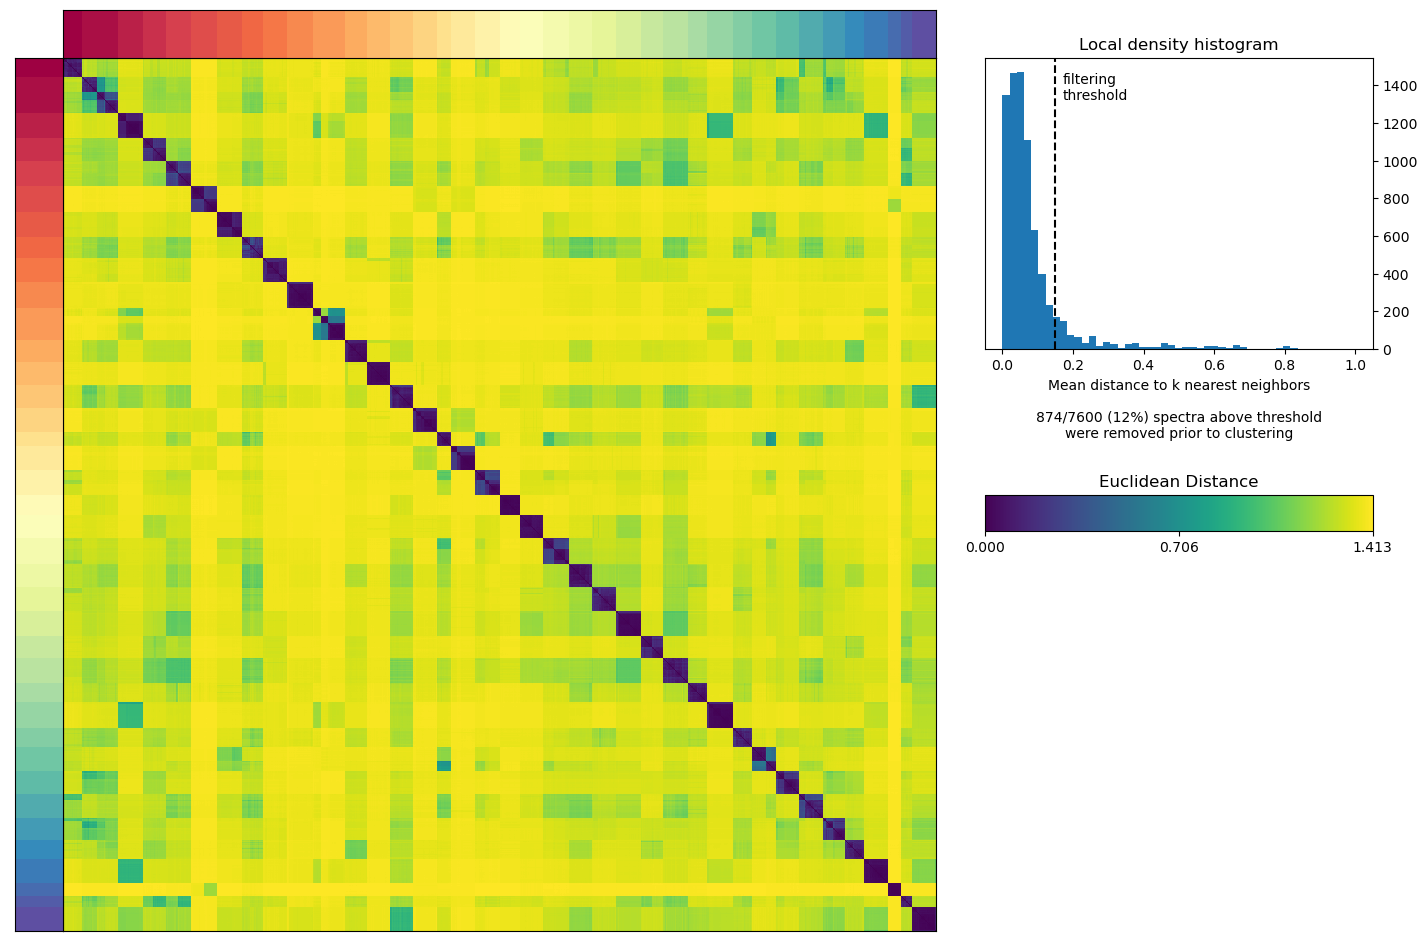

In [27]:
cnmf_obj.consensus(k=38, density_threshold=0.15)

In [33]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T
tcat_spectra_all.head()

CellCycle-G2M_CellCycle_G2M       gdT       ISG  Metallothionein  \
GUF1                       0.000027 -0.000082 -0.000015        -0.000099   
CDR2                       0.000041 -0.000345 -0.000052        -0.000121   
BMX                        0.000005 -0.000062  0.000091        -0.000024   
POLR2G                    -0.000033  0.000669 -0.000008        -0.000189   
NRP2                      -0.000017  0.000011 -0.000023         0.000027   

        Cytoskeleton  CellCycle-Sphase_CellCycle_S_DTL/FAM111B      MAIT  \
GUF1       -0.000033                                  0.000126  0.000021   
CDR2       -0.000129                                  0.000006 -0.000215   
BMX        -0.000056                                 -0.000006 -0.000110   
POLR2G      0.000983                                 -0.000011  0.000295   
NRP2       -0.000084                                  0.000017 -0.000113   

        Doublet_RBC  CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone  \
GUF1       0.000007                                          -0.000069        
CDR2      -0.000237                                          -0.000026        
BMX       -0.000173                                           0.000006        
POLR2G    -0.000129                                           0.000070        
NRP2       0.000009                                           0.000002        

           HeatShock  ...  Pan-Tissue:?C1QC/C1QB/C1QA_Single  \
GUF1    1.964800e-06  ...                          -0.000721   
CDR2    1.097656e-03  ...                          -0.001179   
BMX     6.870846e-08  ...                          -0.000098   
POLR2G -3.714570e-04  ...                          -0.000646   
NRP2    8.149745e-05  ...                           0.001237   

        Pan-Tissue:?PlasmaDoublet_Single  \
GUF1                           -0.000097   
CDR2                           -0.000147   
BMX                            -0.000036   
POLR2G                         -0.000360   
NRP2                           -0.000041   

        Pan-Tissue:?DOK5/CCDC197/LINC02389_Single  \
GUF1                                     0.000050   
CDR2                                    -0.000038   
BMX                                     -0.000009   
POLR2G                                   0.000066   
NRP2                                     0.000071   

        Pan-Tissue:?IGFBP7/STMN1/PIMREG_Single  \
GUF1                                  0.000145   
CDR2                                 -0.000179   
BMX                                  -0.000015   
POLR2G                                0.000670   
NRP2                                  0.000039   

        Pan-Tissue:LungMyeloidDoublet_Single  \
GUF1                               -0.000171   
CDR2                               -0.000061   
BMX                                 0.000116   
POLR2G                             -0.000148   
NRP2                                0.000346   

        Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5_Single  \
GUF1                                        -0.000002   
CDR2                                         0.000646   
BMX                                         -0.000125   
POLR2G                                       0.000685   
NRP2                                        -0.000103   

        Pan-Tissue:?Plasmablast_Single  Pan-Tissue:Doublet_Plasmablast_Single  \
GUF1                         -0.000110                              -0.000207   
CDR2                         -0.000159                              -0.000701   
BMX                           0.000009                              -0.000053   
POLR2G                       -0.000034                               0.000893   
NRP2                         -0.000082                              -0.000024   

        Pan-Tissue:Doublet_Plasmablast2_Single  \
GUF1                                 -0.000043   
CDR2                                 -0.000223   
BMX                                  -0.000007   
POLR2G                        

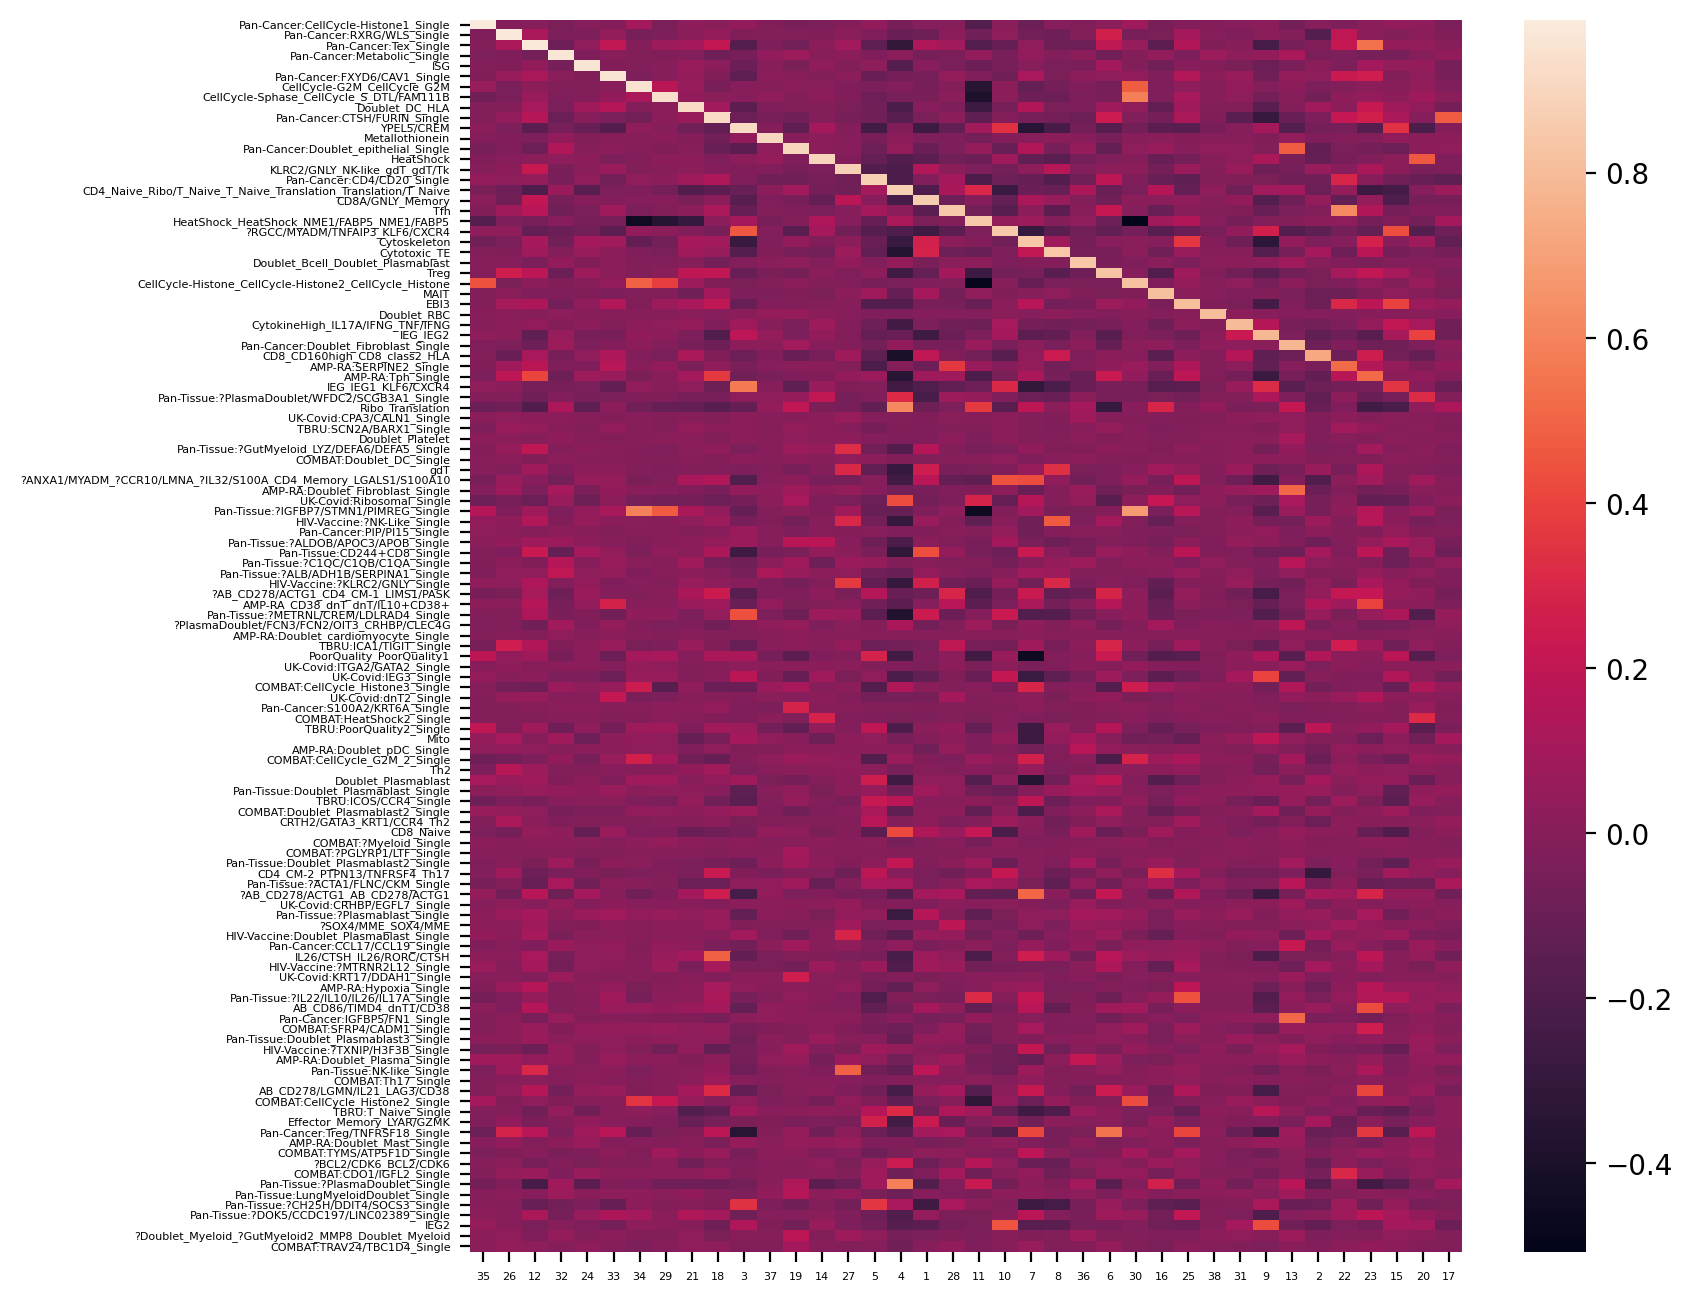

In [34]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=38, density_threshold=0.15)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [46]:
res = []
k=38

R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'HIV-Vaccine', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'Pan-Cancer'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0) & ~merge_annotation['Y_columns'].isnull()
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  38                33                             23   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            11                     10               5   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0

In [47]:
merge_annotation.loc[new_singleton_match_ind, :]

Empty DataFrame
Columns: [Y_columns, X_columns, R, AMP-RA, UK-Covid, Pan-Tissue, HIV-Vaccine, COMBAT, TBRU, Pan-Cancer]
Index: []

In [48]:
merge_annotation.loc[this_dataset_singletons_ind, :]

Y_columns                                       X_columns         R  \
4111.0       35.0            Pan-Cancer:CellCycle-Histone1_Single  0.985570   
3037.0       26.0                      Pan-Cancer:RXRG/WLS_Single  0.978339   
1366.0       12.0                           Pan-Cancer:Tex_Single  0.972370   
3755.0       32.0                     Pan-Cancer:Metabolic_Single  0.962647   
3871.0       33.0                    Pan-Cancer:FXYD6/CAV1_Single  0.957517   
2081.0       18.0                    Pan-Cancer:CTSH/FURIN_Single  0.918146   
2202.0       19.0            Pan-Cancer:Doublet_epithelial_Single  0.899255   
532.0         5.0                      Pan-Cancer:CD4/CD20_Single  0.874050   
1102.0       10.0                  ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  0.848069   
1489.0       13.0            Pan-Cancer:Doublet_Fibroblast_Single  0.779553   
2369.0       20.0  Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single  0.318546   

       AMP-RA UK-Covid                               Pan-Tissue HIV-Vaccine  \
4111.0    NaN      NaN                                      NaN         NaN   
3037.0    NaN      NaN                                      NaN         NaN   
1366.0    NaN      NaN                                      NaN         NaN   
3755.0    NaN      NaN                                      NaN         NaN   
3871.0    NaN      NaN                                      NaN         NaN   
2081.0    NaN      NaN                                      NaN         NaN   
2202.0    NaN      NaN                                      NaN         NaN   
532.0     NaN      NaN                                      NaN         NaN   
1102.0    NaN      NaN           Pan-Tissue:?RGCC/MYADM/TNFAIP3         NaN   
1489.0    NaN      NaN                                      NaN         NaN   
2369.0    NaN      NaN  Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1         NaN   

       COMBAT TBRU                     Pan-Cancer  
4111.0    NaN  NaN  Pan-Cancer:CellCycle-Histone1  
3037.0    NaN  NaN            Pan-Cancer:RXRG/WLS  
1366.0    NaN  NaN                 Pan-Cancer:Tex  
3755.0    NaN  NaN           Pan-Cancer:Metabolic  
3871.0    NaN  NaN          Pan-Cancer:FXYD6/CAV1  
2081.0    NaN  NaN          Pan-Cancer:CTSH/FURIN  
2202.0    NaN  NaN  Pan-Cancer:Doublet_epithelial  
532.0     NaN  NaN            Pan-Cancer:CD4/CD20  
1102.0    NaN  NaN          Pan-Cancer:KLF6/CXCR4  
1489.0    NaN  NaN  Pan-Cancer:Doublet_Fibroblast  
2369.0    NaN  NaN                            NaN

In [49]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity             7  NaN  
ISG                                       Known Activity             7  NaN  
gdT                                        Known Lineage             4  NaN  
Metallothionein                           Known Activity             5  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity             7  NaN

In [55]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
count = 1
gep2rename = {}
for g in gep2meta.keys():
    if gep2meta[g] in meta2rename:
        gep2rename[g] = meta2rename[gep2meta[g]]
    else:
        gep2rename[g] = gep2meta[g] #'Pan-Cancer:%d' % count
        count += 1

In [56]:
pd.Series(gep2rename).sort_index()

1                                          CD8/KLRC2
2                                             CD8_EM
3                                         YPEL5/CREM
4                                          CD4-Naive
5                         Pan-Cancer:CD4/CD20_Single
6                                               Treg
7                                       Cytoskeleton
8                                          Cytotoxic
9                                         IEG-Tissue
10                                        RGCC/MYADM
11                                        HeatShock2
12                                        Exhaustion
13              Pan-Cancer:Doublet_Fibroblast_Single
14                                        HeatShock1
15                                               IEG
16                                              MAIT
17                                       Translation
18                                        CTSH/Furin
19              Pan-Cancer:Doublet_epithelial_

In [57]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [58]:
top_genes_relabed

0         1   \
CD8/KLRC2                                          ZNF683      HOPX   
CD8_EM                                               GZMK      CMC1   
YPEL5/CREM                                         ZNF331     ZFP36   
CD4-Naive                                            RPS8     RPL32   
Pan-Cancer:CD4/CD20_Single                         CD40LG     TXNIP   
Treg                                                FOXP3    CARD16   
Cytoskeleton                                         ACTB      PFN1   
Cytotoxic                                          FGFBP2      NKG7   
IEG-Tissue                                           FOSB       FOS   
RGCC/MYADM                                           LMNA     MYADM   
HeatShock2                                           NME1     C1QBP   
Exhaustion                                          KRT86   KIR2DL4   
Pan-Cancer:Doublet_Fibroblast_Single                  LUM    COL1A2   
HeatShock1                                          HSPD1  HSP90AA1   
IEG                                                   REL     KDM6B   
MAIT                                              SLC4A10     KLRB1   
Translation                                     MTRNR2L12  MTRNR2L8   
CTSH/Furin                                           CTSH      IL26   
Pan-Cancer:Doublet_epithelial_Single                 TFF1     KRT19   
Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single     HSPA1B      RHOB   
HLA                                               HLA-DRA  HLA-DRB1   
AMP-RA:SERPINE2_Single                              IGFL2       NMB   
Tph                                                  LAG3    HAVCR2   
ISG                                                   MX1     ISG15   
EBI3-Activation                                     CCL22   TNFRSF4   
Pan-Cancer:RXRG/WLS_Single                           RXRG       WLS   
gdT                                                TYROBP    FCER1G   
Tfh                                                  TOX2     SMCO4   
CellCycle-S                                           TK1     GINS2   
CellCycle-Histone                                    RRM2      TUBB   
High-Cytokine                                      CCL4L2      CCL4   
Pan-Cancer:Metabolic_Single                          GPX3      MIOX   
Pan-Cancer:FXYD6/CAV1_Single                        FXYD6     FXYD2   
CellCycle-G2M                                       CDC20      PLK1   
Pan-Cancer:CellCycle-Histone1_Single             HIST1H3C  HIST1H3B   
Doublet-Bcell                                       BANK1      CD19   
Metallothionein                                      MT1X      MT2A   
Doublet-RBC                                           HBB      HBA2   

                                                       2          3   \
CD8/KLRC2                                            CD8A      KLRC1   
CD8_EM                                               CST7      EOMES   
YPEL5/CREM                                         ATP1B3       FTH1   
CD4-Naive                                            CCR7      RPS13   
Pan-Cancer:CD4/CD20_Single                          FKBP5       IL7R   
Treg                                                RTKN2       BATF   
Cytoskeleton                                        ACTG1       CFL1   
Cytotoxic                                            GZMH     PRSS23   
IEG-Tissue                                          DUSP1       EGR1   
RGCC/MYADM                                          CRIP1        VIM   
HeatShock2                                           NPM1      PYCR1   
Exhaustion                                         ATP8B4      MYO1E   
Pan-Cancer:Doublet_Fibroblast_Single               COL3A1        DCN   
HeatShock1                                          HSPE1      HSPH1   
IEG                                                  PIM3      NFKB1   
MAIT                                                IL4I1        CA2   
Translation                                     MAP1LC3B2   M

In [60]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200.Spectra_TPM.Relabeled.tsv


# K=43

In [63]:
paths

{'Original': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.TP10K.h5ad'}

In [64]:
os.path.abspath(paths['RNA_Varnorm_Harmony'])

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [65]:
name

'PanCancer.20232005.NoBlood.Iter200'

In [66]:
cnmfdir = '../../../Data/PerDataset/Pancancer'
name = 'PanCancer.20232005.NoBlood.Iter200'

In [67]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(43, 44)
n_iter = 200
num_per_node = 4

In [68]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [69]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [70]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [58]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J PanCancer.20232005.NoBlood.Iter200 -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.0.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name PanCancer.20232005.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/Pancancer --total-workers 50 --worker-index 0"
Job <887351> is submitted to queue <short>.
bsub -q short -J PanCancer.20232005.NoBlood.Iter200 -o ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.1.out.txt -e ../../../Data/PerDataset/Pancancer/PanCancer.20232005.NoBlood.Iter200/log/PanCancer.20232005.NoBlood.Iter200.1.err.txt -R "rusage[mem=20

In [71]:
! bjobs

No unfinished job found


In [72]:
! bjobs | wc -l

No unfinished job found
0


In [73]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [74]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [75]:
missing

[]

In [76]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [77]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

In [78]:
! bjobs

No unfinished job found


## Look at the results for K=43 with 200 iterations

In [79]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=43.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


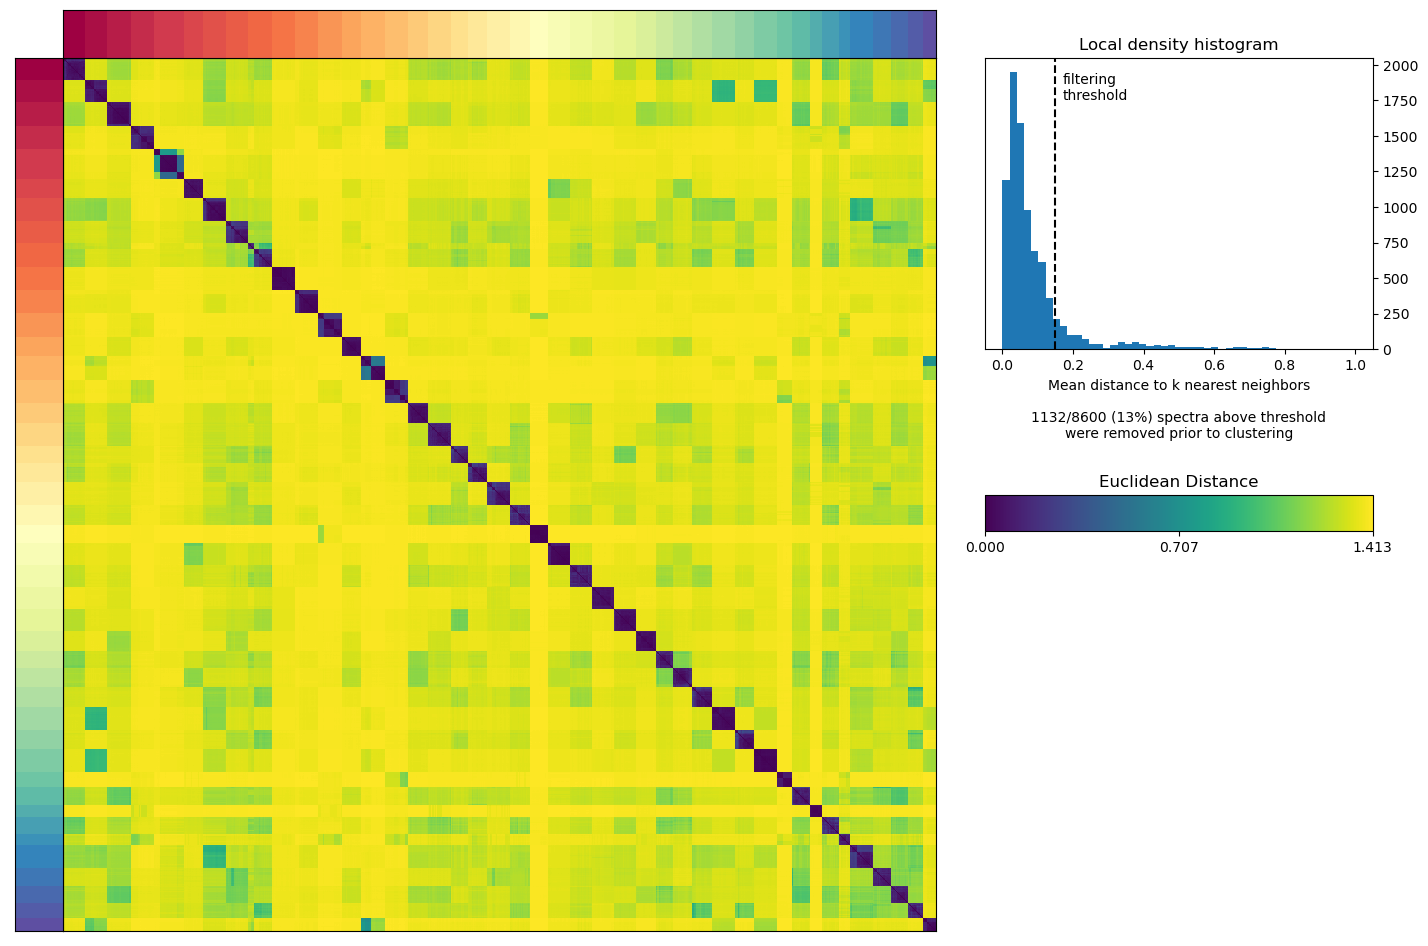

In [80]:
cnmf_obj.consensus(k=43, density_threshold=0.15)

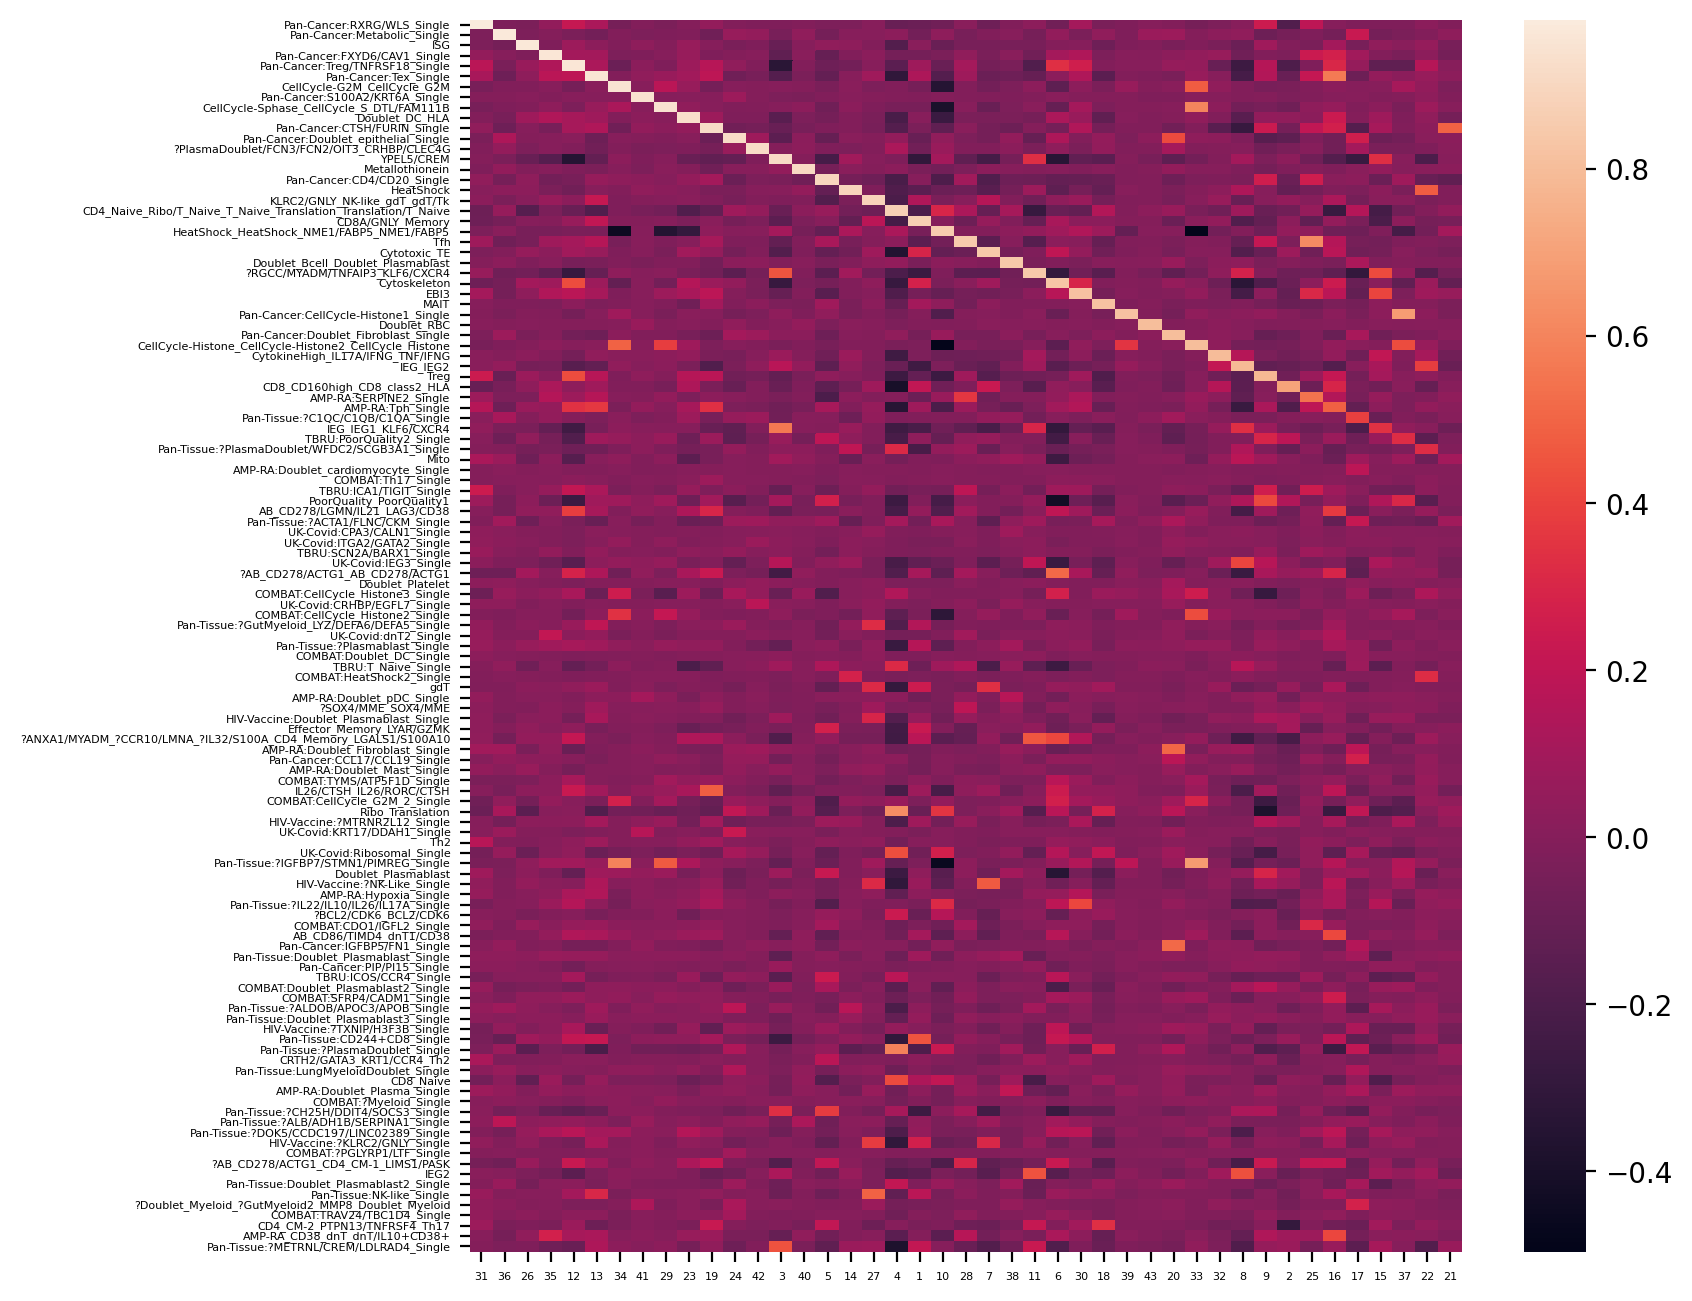

In [84]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=43, density_threshold=0.15)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [85]:
res = []
k=43
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  43                36                             23   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            35                     13               7   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0

In [86]:
merge_annotation.loc[this_dataset_singletons_ind, :]

Y_columns                                       X_columns         R  \
3632.0       31.0                      Pan-Cancer:RXRG/WLS_Single  0.978377   
4231.0       36.0                     Pan-Cancer:Metabolic_Single  0.968215   
4109.0       35.0                    Pan-Cancer:FXYD6/CAV1_Single  0.956984   
1368.0       12.0                 Pan-Cancer:Treg/TNFRSF18_Single  0.955467   
1485.0       13.0                           Pan-Cancer:Tex_Single  0.950684   
4828.0       41.0                  Pan-Cancer:S100A2/KRT6A_Single  0.940822   
2200.0       19.0                    Pan-Cancer:CTSH/FURIN_Single  0.920719   
2797.0       24.0            Pan-Cancer:Doublet_epithelial_Single  0.918329   
4915.0       42.0      ?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G  0.915411   
532.0         5.0                      Pan-Cancer:CD4/CD20_Single  0.895860   
1221.0       11.0                  ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  0.840304   
4587.0       39.0            Pan-Cancer:CellCycle-Histone1_Single  0.817707   
2322.0       20.0            Pan-Cancer:Doublet_Fibroblast_Single  0.804550   
2013.0       17.0               Pan-Tissue:?C1QC/C1QB/C1QA_Single  0.389088   
2607.0       22.0  Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single  0.324933   
NaN           NaN                    Pan-Cancer:IGFBP5/FN1_Single       NaN   
NaN           NaN                   Pan-Cancer:CCL17/CCL19_Single       NaN   
NaN           NaN                      Pan-Cancer:PIP/PI15_Single       NaN   
NaN           NaN          Pan-Tissue:?METRNL/CREM/LDLRAD4_Single       NaN   
NaN           NaN                     Pan-Tissue:CD244+CD8_Single       NaN   
NaN           NaN            Pan-Tissue:?CH25H/DDIT4/SOCS3_Single       NaN   
NaN           NaN               Pan-Tissue:?ACTA1/FLNC/CKM_Single       NaN   
NaN           NaN                       Pan-Tissue:NK-like_Single       NaN   
NaN           NaN             Pan-Tissue:?ALDOB/APOC3/APOB_Single       NaN   
NaN           NaN         Pan-Tissue:?IL22/IL10/IL26/IL17A_Single       NaN   
NaN           NaN           Pan-Tissue:?ALB/ADH1B/SERPINA1_Single       NaN   
NaN           NaN                Pan-Tissue:?PlasmaDoublet_Single       NaN   
NaN           NaN       Pan-Tissue:?DOK5/CCDC197/LINC02389_Single       NaN   
NaN           NaN          Pan-Tissue:?IGFBP7/STMN1/PIMREG_Single       NaN   
NaN           NaN            Pan-Tissue:LungMyeloidDoublet_Single       NaN   
NaN           NaN   Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5_Single       NaN   
NaN           NaN                  Pan-Tissue:?Plasmablast_Single       NaN   
NaN           NaN           Pan-Tissue:Doublet_Plasmablast_Single       NaN   
NaN           NaN          Pan-Tissue:Doublet_Plasmablast2_Single       NaN   
NaN           NaN          Pan-Tissue:Doublet_Plasmablast3_Single       NaN   

       AMP-RA UK-Covid                                Pan-Tissue HIV-Vaccine  \
3632.0    NaN      NaN                                       NaN         NaN   
4231.0    NaN      NaN                                       NaN         NaN   
4109.0    NaN      NaN                                       NaN         NaN   
1368.0    NaN      NaN                                       NaN         NaN   
1485.0    NaN      NaN                                       NaN         NaN   
4828.0    NaN      NaN                                       NaN         NaN   
2200.0    NaN      NaN                                       NaN         NaN   
2797.0    NaN      NaN                                       NaN         NaN   
4915.0    NaN      NaN  Pan-Tissue:?PlasmaDoublet/FCN3/FCN2/OIT3         NaN   
532.0     NaN      NaN                                       NaN         NaN   
1221.0    NaN      NaN            Pan-Tissue:?RGCC/MYADM/TNFAIP3         NaN   
4587.0    NaN      NaN                                       NaN         NaN   
2322.0    NaN      NaN                                       NaN         NaN   
2013.0    NaN      NaN                Pan-T